# Load dataset

In [1]:
!cp /content/drive/MyDrive/PMCC/Dataset/mnMaskLabel.zip /content
!unzip /content/mnMaskLabel.zip

Archive:  /content/mnMaskLabel.zip
   creating: mnMask/
   creating: mnMask/data/
   creating: mnMask/data/.ipynb_checkpoints/
   creating: mnMask/data/label_masks/
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y06m30d_12h02m-12.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_G20_1_2022y12m01d_23h30m-25.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m03d_07h02m-9.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_E12_1_2022y12m05d_11h30m-3.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_E5_1_2022y12m03d_23h30m-24.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_B1_2_2023y06m26d_14h17m_0.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_A1_1_2023y06m26d_01h17m_0.npy  
  inflating: mnMask/data/label_masks/Plate 1_GFP-H2B_D16_1_2022y12m05d_15h30m-6.npy  
  inflating: mnMask/data/label_masks/10 Gy_GFP-H2B_A1_3_2023y06m24d_21h17m_2.npy  
  inflating: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m02d_18h02m-15.npy  
  inflat

In [2]:
import json
import os

data = json.load(open('/content/mnMask/data/result.json'))

In [3]:
len(os.listdir('/content/mnMask/data/masks'))

924

# Load model

### mask RCNN

In [4]:
!cp /content/drive/MyDrive/PMCC/models/RCNN.pt RCNN.pt

!git clone https://github.com/kew6688/MicroNuclei_Detection.git
!pip install -e MicroNuclei_Detection/.

!pip show mn_segmentation
!pwd
%cd /content/MicroNuclei_Detection

Cloning into 'MicroNuclei_Detection'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 262 (delta 127), reused 186 (delta 61), pack-reused 0 (from 0)
Receiving objects: 100% (262/262), 21.36 MiB | 15.48 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Obtaining file:///content/MicroNuclei_Detection
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mn_segmentation (pyproject.toml) ... done
  Created wheel for mn_segmentation: filename=mn_segmentation-0.1.0-py2.py3-none-any.whl size=994 sha256=b33ac4d99acdb08e7f242b39d448dde6fbcbdae0869a4401ee77336fdb26e3d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-v7vr0pus/wheels/44/d3/d1/353d79dc8f5f434b1d33808323c1d5bb1d136026d7ae0912b8
Successfully built m

In [5]:
from mn_segmentation.lib.Application import Application
import importlib
import mn_segmentation.lib.Application # Make sure that this is the correct path to your Application module
importlib.reload(mn_segmentation.lib.Application)

<module 'mn_segmentation.lib.Application' from '/content/MicroNuclei_Detection/mn_segmentation/lib/Application.py'>

In [134]:
import os
from PIL import Image
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm
import matplotlib.pyplot as plt

dataset_path = "/content/mnMask/data"

# miss mn labeled case: "10 Gy_GFP-H2B_A2_3_2023y06m24d_20h17m_5.npy"

file = "GFP-H2B_A1_1_2023y07m03d_01h02m-1.npy"
model = Application("/content/RCNN.pt")

im = Image.open(os.path.join(dataset_path,'images',file[:-4]+".png"))
image = pil_to_tensor(im)
pred = model._predict(image)
pred_boxes,pred_masks,pred_scores = model._post_process(pred, 0.7)
pred_boxes = pred_boxes.cpu().numpy()
pred_masks = np.squeeze(pred_masks.cpu().numpy())       # shape [n,w,h]
pred_scores = pred_scores.cpu().numpy()      # shape [n]
if pred_masks.ndim == 2:
  pred_masks = np.expand_dims(pred_masks, axis=0)
print(pred_masks.shape)
print(pred_scores.shape)

# get GT mask
gt_masks = np.load(os.path.join(dataset_path,'label_masks',file))  # shape [n,w,h]
obj_ids = np.unique(gt_masks)
gt_masks = (gt_masks == obj_ids[:, None, None])
print(gt_masks.shape)


(0, 224, 224)
(0,)
(2, 224, 224)


In [86]:
!rm "/content/mnMask/data/label_masks/Plate 1_GFP-H2B_F17_1_2022y12m06d_07h30m-0.npy"

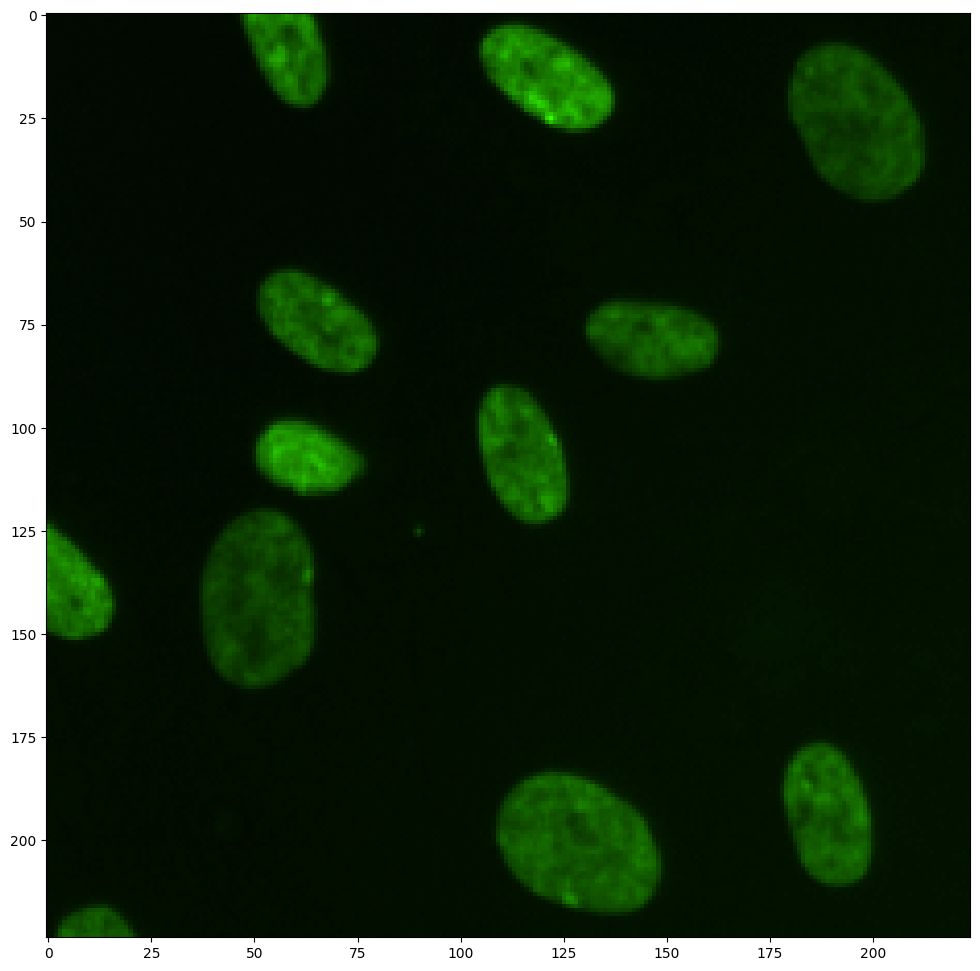

In [135]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image
import torch

image = read_image(os.path.join(dataset_path,'images',file[:-4]+".png"))
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_segmentation_masks(image, torch.from_numpy(pred_masks>0.3), alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

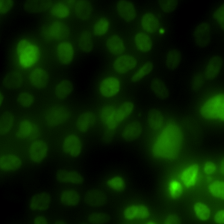

In [121]:
im

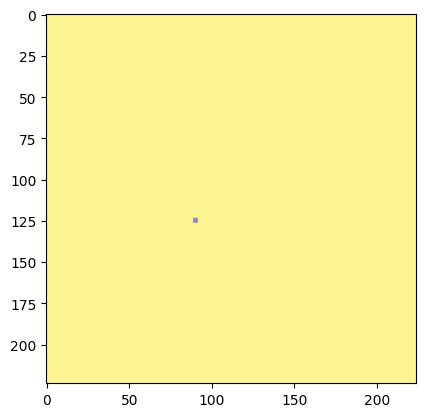

In [136]:
plt.imshow(gt_masks[0],alpha=0.5)

17

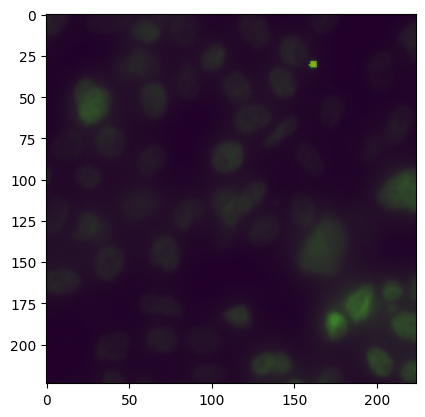

In [123]:
plt.imshow(im)
plt.imshow(gt_masks[1],alpha=0.5)
# np.unique(gt_masks[0])
gt_masks[1].sum()

In [124]:
cnt = 0
for i in range(pred_masks.shape[0]):
  res=False
  overlap=0
  for j in range(gt_masks.shape[0]):
    # if gt_masks[j].sum() > 1000: continue
    intersection = np.logical_and(pred_masks[i]>0.8, gt_masks[j]>0).sum()
    union = np.logical_or(pred_masks[i]>0.8, gt_masks[j]>0).sum()
    iou = intersection / union
    print(intersection,union,iou)
    if intersection > overlap:
      overlap = intersection
      res = True if iou > 0.5 else False
  if res:
    cnt += 1
cnt/(gt_masks.shape[0]-1)

7 50176 0.00013950892857142856
17 24 0.7083333333333334
26 50159 0.0005183516417791423
0 43 0.0
20 50159 0.0003987320321378018
0 37 0.0


1.0

## Eveluate

In [144]:
class Evaluator:
  def __init__(self):
      self.pred_list = []
      self.objects = 0
      self.predictions = 0
      self.TP = 0
      self.FP = 0
      self.FN = 0
      self.precision = 0
      self.recall = 0
      self.f1 = 0
      self.map = 0

  def update(self, pred_masks, pred_scores, gt_masks, ap_iou):
    self.objects += gt_masks.shape[0]-1
    self.predictions += pred_masks.shape[0]
    t_cnt = 0
    for i in range(pred_masks.shape[0]):
      conf = pred_scores[i]
      res = False
      overlap = 0
      for j in range(gt_masks.shape[0]):
        if gt_masks[j].sum()>1000 or gt_masks[j].sum()<5: continue
        intersection = np.logical_and(pred_masks[i], gt_masks[j]).sum()
        union = np.logical_or(pred_masks[i], gt_masks[j]).sum()
        iou = intersection / union
        if intersection > overlap:
          overlap = intersection
          res = True if iou > ap_iou else False
      if res:
        self.TP += 1
        t_cnt += 1
      else:
        self.FP += 1
      self.pred_list.append((conf, res))
    return t_cnt/(gt_masks.shape[0]-1) if (gt_masks.shape[0]-1) > 0 else 1

  def finalize(self):
    self.FN = self.objects - self.TP
    self.pred_list.sort(key=lambda x: x[0], reverse=True)
    correct = 0
    for i in range(len(self.pred_list)):
      if self.pred_list[i][1]:
        correct += 1
      self.map += correct / (i + 1)
    self.map /= self.predictions
    print(f"mAP: {self.map}")

    self.precision = self.TP / (self.TP + self.FP)
    self.recall = self.TP / (self.TP + self.FN)
    self.f1 = 2 * self.precision * self.recall / (self.precision + self.recall)
    print(f"precision: {self.precision}")
    print(f"recall: {self.recall}")
    print(f"f1: {self.f1}")

    return self.precision, self.recall, self.f1

  def draw_pr_curve(self):
    p = []
    r = []
    correct = 0
    for i in range(len(self.pred_list)):
      if self.pred_list[i][1]:
        correct += 1
      p.append(correct / (i + 1))
      r.append(correct / self.objects)
    plt.plot(r, p)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    print(f"Average Precision: {sum(p)/len(p)}")


In [146]:
import os
from PIL import Image
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluate_mn_dataset(model, dataset_path, evaluator, nms_iou=0.2, conf=0.4, ap_iou=0.5):
  for file in tqdm(os.listdir(os.path.join(dataset_path,'label_masks'))[-200:]):
    # get final pred, may need customize model predict function
    im = Image.open(os.path.join(dataset_path,'images',file[:-4]+".png"))
    image = pil_to_tensor(im)
    pred = model._predict(image)
    pred_boxes,pred_masks,pred_scores = model._post_process(pred, conf)
    pred_boxes = pred_boxes.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()
    pred_masks = (pred_masks > conf).squeeze(1)       # shape [n,w,h]
    pred_scores = pred_scores.cpu().numpy()           # shape [n]
    if pred_masks.ndim == 2:
      pred_masks = np.expand_dims(pred_masks, axis=0)
    # print(pred_masks.shape)
    # print(pred_scores.shape)

    # get GT mask
    gt_masks = np.load(os.path.join(dataset_path,'label_masks',file))  # shape [n,w,h]
    obj_ids = np.unique(gt_masks)
    gt_masks = (gt_masks == obj_ids[:, None, None])
    # print(gt_masks.shape)

    # compare and update
    recall = evaluator.update(pred_masks, pred_scores, gt_masks, ap_iou)

    # uncomment this can give bad cases that cause recall drop, missing mn
    # if recall < 0.5:
    #   print(recall,file)

  evaluator.finalize()
  # evaluator.draw_pr_curve()
  return

In [153]:
model = Application("/content/RCNN.pt")

ap = []
p = []
f1 = []
for i in range(10):
  print(f"============== conf: {i/10} =============")
  evaluator = Evaluator()
  evaluate_mn_dataset(model, "/content/mnMask/data", evaluator, conf=i/10, ap_iou=0.25)
  ap.append(evaluator.map)
  p.append(evaluator.precision)
  f1.append(evaluator.f1)

  # if i == 7:
  #   evaluator.draw_pr_curve()

============== conf: 0.0 =============


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


mAP: 0.7824550449395653
precision: 0.5714285714285714
recall: 1.0429042904290429
f1: 0.7383177570093458
============== conf: 0.1 =============


100%|██████████| 200/200 [00:08<00:00, 23.05it/s]


mAP: 0.8021231288958812
precision: 0.6147704590818364
recall: 1.0165016501650166
f1: 0.7661691542288558
============== conf: 0.2 =============


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


mAP: 0.8152930263803476
precision: 0.6616379310344828
recall: 1.0132013201320131
f1: 0.8005215123859191
============== conf: 0.3 =============


100%|██████████| 200/200 [00:08<00:00, 23.43it/s]


mAP: 0.822739219122602
precision: 0.6848072562358276
recall: 0.9966996699669967
f1: 0.8118279569892473
============== conf: 0.4 =============


100%|██████████| 200/200 [00:08<00:00, 23.25it/s]


mAP: 0.8307684833309437
precision: 0.7263922518159807
recall: 0.9900990099009901
f1: 0.8379888268156426
============== conf: 0.5 =============


100%|██████████| 200/200 [00:08<00:00, 23.29it/s]


mAP: 0.83553910475955
precision: 0.7506361323155216
recall: 0.9735973597359736
f1: 0.8477011494252874
============== conf: 0.6 =============


100%|██████████| 200/200 [00:08<00:00, 23.21it/s]


mAP: 0.8392749705366742
precision: 0.7754010695187166
recall: 0.9570957095709571
f1: 0.8567208271787297
============== conf: 0.7 =============


100%|██████████| 200/200 [00:08<00:00, 23.42it/s]


mAP: 0.8440302156279823
precision: 0.8005865102639296
recall: 0.900990099009901
f1: 0.8478260869565216
============== conf: 0.8 =============


100%|██████████| 200/200 [00:08<00:00, 23.43it/s]


mAP: 0.8530990108839127
precision: 0.8218181818181818
recall: 0.7458745874587459
f1: 0.7820069204152249
============== conf: 0.9 =============


100%|██████████| 200/200 [00:08<00:00, 23.50it/s]

mAP: 0.87493830452506
precision: 0.8188976377952756
recall: 0.3432343234323432
f1: 0.4837209302325581


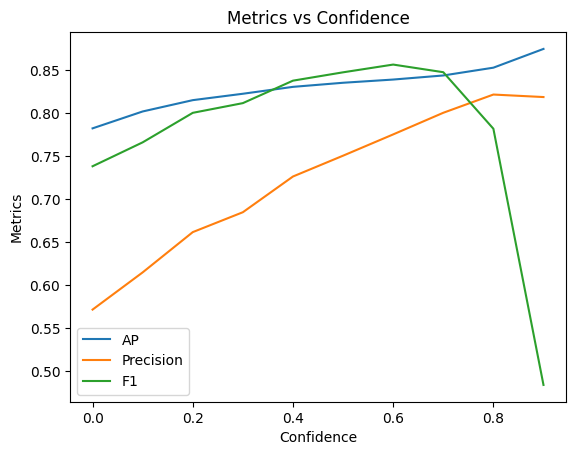

In [154]:
plt.plot(np.arange(10)/10, ap)
plt.plot(np.arange(10)/10, p)
plt.plot(np.arange(10)/10, f1)
plt.legend(['AP', 'Precision', 'F1'])
plt.xlabel('Confidence')
plt.ylabel('Metrics')
plt.title('Metrics vs Confidence')
plt.show()


In [114]:
import json

# Example lists

# Create a dictionary from the lists
data = {
    "ap": ap,
    "p": p,
    "f1": f1
}

# Write the dictionary to a JSON file
with open("maskrcnn_resnet50.json", "w") as json_file:
    json.dump(data, json_file, indent=4)  # indent=4 for pretty printing

# Nuc

In [20]:
!cp /content/drive/MyDrive/PMCC/Dataset/uncrop.zip /content
!unzip /content/uncrop.zip

Archive:  /content/uncrop.zip
  inflating: uncrop/classes.txt      
   creating: uncrop/images/
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_19h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_20h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_21h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_22h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_23h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_00h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_01h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_02h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_03h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_04h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_05h17m.png  
  inflating: uncrop/images/10 Gy_GFP-H2B_A1_1_2023y0

In [21]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    min_mask_region_area=25
)

PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-8wxp46n6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-8wxp46n6
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.2 MB/s eta 0:00:00
  Created w

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image


def load_img(img_path):
  """
  Read an image and convert it to RGB format.

  Args:
    img_path (str): Path to the image file.

  Returns:
    Img object: Image object from PIL.
    numpy.ndarray: RGB image array from Image.open.
  """

  img = Image.open(img_path)
  img_arr = np.array(img)
  return img, img_arr

def load_polys(label_path, target_clas = 7, xy_length=(224,224)):
  """
  Read a label txt file and convert it to numpy array.

  Args:
    label_path (str): Path to the label text file.

  Returns:
    numpy.ndarray: polygon array that each polygon contains an array of coordinates ([[x,y],...]).
  """

  poly_arr = []
  with open(label_path, 'r') as label_file:
    # Read and print each line in the file
    for line in label_file:
      l = line.strip().split()
      # class type:
          #   4: cell_active_div, 5: cell_non_div, 6: cell_sick_apop, 7: micronuclei
      cls, points = int(l[0]), l[1:]

      # current focus on mn
      if cls != target_clas:
        continue

      points = np.array(points, dtype=np.float64).reshape((-1, 2))
      points = convert_poly_points(xy_length, points)
      poly_arr.append(points)
  return poly_arr

def convert_poly_points(xy_length, points):
  points = points*xy_length
  points = points.astype(np.int32)
  return points

def change_origin(origin, wnd_size, points):
  """
  Crop an image based on the given points. Change the points relative coordinates regards to the origin.
  yolo format with relative coordinates: (x - origin_x) / 224, (y - origin_y) / 224
  the window size and origin changed.

  Args:
    origin: array of [x,y]
    wnd_size: int or array of [x,y]
  Returns:

  """
  pts = (points - origin) / wnd_size
  return pts

def convert_ROI_dataset(data_dir, dest_dir):
  image_dir = data_dir + 'images/'
  label_dir = data_dir + 'labels/'

  img_cnt = 0
  mn_cnt = 0

  for file in os.listdir(image_dir):
    img_name = file.split('.')[0]

    # read image
    img, img_arr = load_img(image_dir + file)

    # read polygons
    polys = load_polys(label_dir + img_name + '.txt')

    # points to pixel integer
    xy_length = np.array([img_arr.shape[1], img_arr.shape[0]])
    for i,poly in enumerate(polys):
      points = convert_poly_points(xy_length, poly)

      # crop image, save to dest
      x,y = points[0]
      w,h = 112, 112
      img2 = img.crop((x-w,y-h,x+w,y+h))
      img2.save(dest_dir + "images/" + img_name + '_' + str(i) + '.png')
      img_cnt += 1

      # write label
      new_pts = change_origin(np.array([x-w,y-h]), 224, points)
      write_buffer = []
      write_buffer.append("1 " + " ".join(map(str, new_pts.flatten())))

      # check if any other mn in the window
      for j,poly in enumerate(polys):
        if j == i: continue
        pt = poly[0]*xy_length
        if x-w < pt[0] < x+w and y-h < pt[1] < y+h:
          new_pts = change_origin(np.array([x-w,y-h]), 224, poly)
          write_buffer.append("1 " + " ".join(map(str, new_pts.flatten())))

      with open(dest_dir + "labels/" + img_name + '_' + str(i) + '.txt', 'w') as the_file:
        the_file.write("\n".join(write_buffer))
        mn_cnt += len(write_buffer)

  print("image cnt: {}, mn cnt: {}".format(img_cnt, mn_cnt))

def display(img, points):
    cv2.fillPoly(img, pts=[points], color=(255, 0, 255))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img)


In [23]:
def evaluate_nuc_dataset(model, dataset_path, evaluator, nms_iou=0.2, conf=0.4, ap_iou=0.5):
  for file in tqdm(os.listdir(os.path.join(dataset_path,'labels'))):
    # get final pred, may need customize model predict function
    image = Image.open(os.path.join(dataset_path,'images',file[:-4]+".png"))
    image = np.array(image.convert("RGB"))
    masks = mask_generator.generate(image)
    # print(len(masks))
    # print(masks[0]['segmentation'].shape)
    pred_masks = []
    pred_scores = []
    for mask in masks:
      if mask['bbox'][3] > 900 and mask['bbox'][2] > 900:
        continue
      pred_masks.append(mask['segmentation'])
      pred_scores.append(mask['predicted_iou'])

    # get GT mask
    points = load_polys(os.path.join(dataset_path,'labels',file), target_clas = 5, xy_length=(1408,1040))
    gt_masks = []
    for p in points:
      im = np.zeros((1040,1408),dtype=np.uint8)
      cv2.fillPoly( im, points, 255 )
      gt_masks.append(im)

    # compare and update
    evaluator.update(np.array(pred_masks), np.array(pred_scores), np.array(gt_masks), ap_iou)

  evaluator.finalize()
  evaluator.draw_pr_curve()
  return

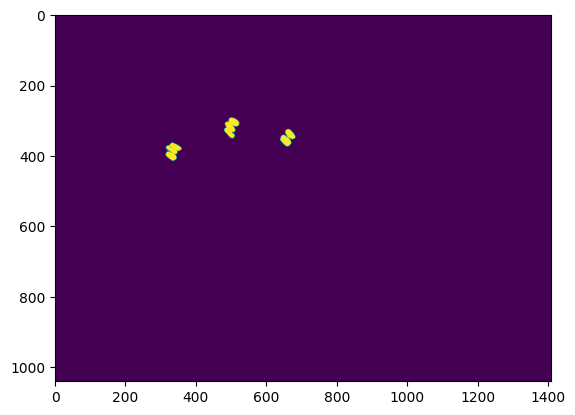

In [26]:
points = load_polys("/content/MicroNuclei_Detection/uncrop/labels/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m.txt", target_clas = 5, xy_length=(1408,1040))
im = np.zeros((1040,1408),dtype=np.uint8)
plt.imshow(cv2.fillPoly( im, points, 255 ))

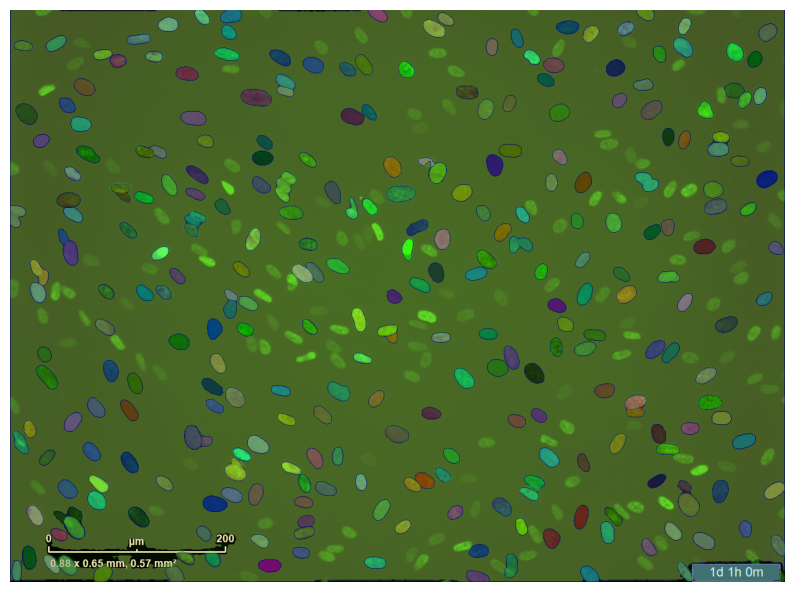

In [28]:
img = Image.open("/content/MicroNuclei_Detection/uncrop/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m.png")
img = np.array(img.convert("RGB"))
masks = mask_generator.generate(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show()

282


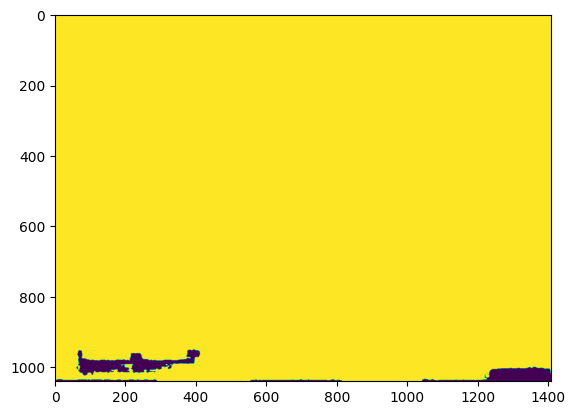

In [32]:
print(len(masks))
plt.imshow(masks[0]['segmentation'])

In [ ]:
evaluator = Evaluator()
evaluate_nuc_dataset(mask_generator, "/content/uncrop", evaluator, conf=0.4, ap_iou=0.5)

  0%|          | 0/145 [00:00<?, ?it/s]

(1040, 1408)


  1%|          | 1/145 [00:20<48:29, 20.21s/it]

(1040, 1408)


  1%|▏         | 2/145 [00:41<49:10, 20.63s/it]

(1040, 1408)


  2%|▏         | 3/145 [00:59<45:55, 19.40s/it]

(1040, 1408)


  3%|▎         | 4/145 [01:56<1:20:36, 34.30s/it]

(1040, 1408)


  3%|▎         | 5/145 [02:55<1:41:17, 43.41s/it]

(1040, 1408)


  4%|▍         | 6/145 [03:21<1:26:52, 37.50s/it]

(1040, 1408)


  5%|▍         | 7/145 [04:38<1:55:28, 50.21s/it]

(1040, 1408)


  6%|▌         | 8/145 [05:52<2:12:26, 58.00s/it]

(1040, 1408)


  6%|▌         | 9/145 [06:41<2:04:38, 54.99s/it]

(1040, 1408)


  7%|▋         | 10/145 [07:26<1:56:44, 51.89s/it]

(1040, 1408)


  8%|▊         | 11/145 [07:46<1:34:00, 42.09s/it]

(1040, 1408)


  8%|▊         | 12/145 [08:05<1:18:06, 35.23s/it]

(1040, 1408)


  9%|▉         | 13/145 [08:26<1:07:46, 30.81s/it]

(1040, 1408)


 10%|▉         | 14/145 [08:47<1:01:06, 27.99s/it]

(1040, 1408)


 10%|█         | 15/145 [09:08<55:39, 25.69s/it]  

(1040, 1408)


 11%|█         | 16/145 [09:27<51:28, 23.95s/it]

(1040, 1408)


 12%|█▏        | 17/145 [09:47<48:06, 22.55s/it]

(1040, 1408)


 12%|█▏        | 18/145 [10:29<1:00:11, 28.44s/it]

(1040, 1408)


 13%|█▎        | 19/145 [10:46<52:38, 25.07s/it]  

(1040, 1408)


 14%|█▍        | 20/145 [11:06<49:03, 23.55s/it]

(1040, 1408)


 14%|█▍        | 21/145 [11:27<46:55, 22.70s/it]

(1040, 1408)


 15%|█▌        | 22/145 [11:43<42:12, 20.59s/it]

(1040, 1408)


 16%|█▌        | 23/145 [12:18<50:42, 24.94s/it]

(1040, 1408)


 17%|█▋        | 24/145 [12:38<47:44, 23.67s/it]

(1040, 1408)


 17%|█▋        | 25/145 [13:54<1:18:36, 39.30s/it]

(1040, 1408)


 18%|█▊        | 26/145 [14:14<1:06:38, 33.60s/it]

(1040, 1408)


 19%|█▊        | 27/145 [14:33<57:30, 29.24s/it]  

(1040, 1408)


 19%|█▉        | 28/145 [15:43<1:20:39, 41.36s/it]

(1040, 1408)


 20%|██        | 29/145 [16:02<1:06:57, 34.63s/it]

(1040, 1408)


 21%|██        | 30/145 [17:13<1:27:27, 45.63s/it]

(1040, 1408)


 21%|██▏       | 31/145 [17:33<1:12:10, 37.99s/it]

(1040, 1408)


 22%|██▏       | 32/145 [17:52<1:00:21, 32.05s/it]

(1040, 1408)


 23%|██▎       | 33/145 [18:29<1:02:59, 33.75s/it]

(1040, 1408)


 23%|██▎       | 34/145 [19:35<1:20:18, 43.41s/it]

(1040, 1408)


 24%|██▍       | 35/145 [19:53<1:05:12, 35.57s/it]

(1040, 1408)


 25%|██▍       | 36/145 [20:17<58:47, 32.36s/it]  

(1040, 1408)


 26%|██▌       | 37/145 [20:36<50:51, 28.25s/it]

(1040, 1408)


 26%|██▌       | 38/145 [21:01<48:18, 27.09s/it]

(1040, 1408)


 27%|██▋       | 39/145 [21:36<52:27, 29.69s/it]

(1040, 1408)


 28%|██▊       | 40/145 [21:59<48:14, 27.57s/it]

(1040, 1408)


 28%|██▊       | 41/145 [23:06<1:08:12, 39.35s/it]

(1040, 1408)


 29%|██▉       | 42/145 [23:23<56:03, 32.65s/it]  

(1040, 1408)


 30%|██▉       | 43/145 [23:42<48:53, 28.76s/it]

(1040, 1408)


 30%|███       | 44/145 [24:56<1:10:57, 42.15s/it]

(1040, 1408)


 31%|███       | 45/145 [25:32<1:07:17, 40.38s/it]

(1040, 1408)


 32%|███▏      | 46/145 [25:49<55:08, 33.41s/it]  

(1040, 1408)


 32%|███▏      | 47/145 [26:09<47:56, 29.35s/it]

(1040, 1408)


 33%|███▎      | 48/145 [26:31<43:53, 27.15s/it]

(1040, 1408)


 34%|███▍      | 49/145 [27:22<54:53, 34.31s/it]

(1040, 1408)


 34%|███▍      | 50/145 [27:43<47:54, 30.25s/it]

(1040, 1408)


 35%|███▌      | 51/145 [28:10<45:58, 29.35s/it]

(1040, 1408)


 36%|███▌      | 52/145 [29:11<1:00:07, 38.79s/it]

(1040, 1408)


 37%|███▋      | 53/145 [29:31<50:51, 33.17s/it]  

(1040, 1408)


 37%|███▋      | 54/145 [30:09<52:28, 34.60s/it]

(1040, 1408)


 38%|███▊      | 55/145 [30:28<44:58, 29.98s/it]

(1040, 1408)


 39%|███▊      | 56/145 [30:46<38:59, 26.28s/it]

(1040, 1408)


 39%|███▉      | 57/145 [31:06<35:52, 24.46s/it]

(1040, 1408)


 40%|████      | 58/145 [31:30<35:11, 24.27s/it]

(1040, 1408)


 41%|████      | 59/145 [31:49<32:33, 22.72s/it]

(1040, 1408)


 41%|████▏     | 60/145 [32:59<52:28, 37.04s/it]

(1040, 1408)


 42%|████▏     | 61/145 [33:20<44:45, 31.97s/it]

(1040, 1408)


 43%|████▎     | 62/145 [33:34<37:03, 26.79s/it]

(1040, 1408)


 43%|████▎     | 63/145 [34:39<52:13, 38.21s/it]

(1040, 1408)


 44%|████▍     | 64/145 [34:57<43:16, 32.06s/it]

(1040, 1408)


 45%|████▍     | 65/145 [35:15<37:20, 28.01s/it]

(1040, 1408)


 46%|████▌     | 66/145 [35:51<40:01, 30.40s/it]

(1040, 1408)


 46%|████▌     | 67/145 [36:12<35:41, 27.46s/it]

(1040, 1408)


 47%|████▋     | 68/145 [37:08<46:11, 35.99s/it]

(1040, 1408)


 48%|████▊     | 69/145 [37:29<39:55, 31.52s/it]

(1040, 1408)


 48%|████▊     | 70/145 [37:48<34:42, 27.76s/it]

(1040, 1408)


 49%|████▉     | 71/145 [38:16<34:11, 27.72s/it]

(1040, 1408)


 50%|████▉     | 72/145 [38:37<31:22, 25.78s/it]

(1040, 1408)


 50%|█████     | 73/145 [38:56<28:40, 23.90s/it]

(1040, 1408)


 51%|█████     | 74/145 [39:17<27:08, 22.94s/it]

(1040, 1408)


 52%|█████▏    | 75/145 [39:38<25:55, 22.22s/it]

(1040, 1408)


 52%|█████▏    | 76/145 [39:57<24:35, 21.38s/it]

(1040, 1408)


 53%|█████▎    | 77/145 [40:20<24:45, 21.85s/it]

(1040, 1408)


 54%|█████▍    | 78/145 [41:06<32:27, 29.07s/it]

(1040, 1408)


 54%|█████▍    | 79/145 [41:24<28:31, 25.92s/it]

(1040, 1408)


 55%|█████▌    | 80/145 [41:42<25:20, 23.39s/it]

(1040, 1408)


 56%|█████▌    | 81/145 [41:57<22:17, 20.90s/it]

(1040, 1408)


 57%|█████▋    | 82/145 [43:08<37:42, 35.91s/it]

(1040, 1408)


 57%|█████▋    | 83/145 [43:27<31:56, 30.91s/it]

(1040, 1408)


 58%|█████▊    | 84/145 [43:48<28:19, 27.86s/it]

(1040, 1408)


 59%|█████▊    | 85/145 [44:08<25:25, 25.43s/it]

(1040, 1408)


 59%|█████▉    | 86/145 [44:28<23:21, 23.75s/it]

(1040, 1408)


 60%|██████    | 87/145 [44:43<20:38, 21.36s/it]

(1040, 1408)


 61%|██████    | 88/145 [45:04<20:07, 21.18s/it]

(1040, 1408)


 61%|██████▏   | 89/145 [45:22<18:46, 20.12s/it]

(1040, 1408)


 62%|██████▏   | 90/145 [46:25<30:19, 33.08s/it]

(1040, 1408)


 63%|██████▎   | 91/145 [46:45<26:19, 29.25s/it]

(1040, 1408)


 63%|██████▎   | 92/145 [47:06<23:28, 26.58s/it]

(1040, 1408)


 64%|██████▍   | 93/145 [48:17<34:36, 39.92s/it]

(1040, 1408)


 65%|██████▍   | 94/145 [48:35<28:16, 33.26s/it]

(1040, 1408)


 66%|██████▌   | 95/145 [49:17<30:06, 36.14s/it]

(1040, 1408)


 66%|██████▌   | 96/145 [49:57<30:16, 37.06s/it]

(1040, 1408)


 67%|██████▋   | 97/145 [51:07<37:36, 47.02s/it]

(1040, 1408)


 68%|██████▊   | 98/145 [51:23<29:38, 37.84s/it]

(1040, 1408)


 68%|██████▊   | 99/145 [52:20<33:24, 43.57s/it]

(1040, 1408)


 69%|██████▉   | 100/145 [53:32<39:08, 52.19s/it]

(1040, 1408)


 70%|██████▉   | 101/145 [53:53<31:13, 42.58s/it]

(1040, 1408)


 70%|███████   | 102/145 [54:09<24:46, 34.57s/it]

(1040, 1408)


 71%|███████   | 103/145 [54:45<24:29, 34.99s/it]

(1040, 1408)


 72%|███████▏  | 104/145 [55:11<22:14, 32.56s/it]

(1040, 1408)


 72%|███████▏  | 105/145 [55:31<19:05, 28.65s/it]

(1040, 1408)


 73%|███████▎  | 106/145 [56:41<26:39, 41.02s/it]

(1040, 1408)


 74%|███████▍  | 107/145 [57:07<23:11, 36.62s/it]

(1040, 1408)


 74%|███████▍  | 108/145 [57:22<18:28, 29.96s/it]

(1040, 1408)


 75%|███████▌  | 109/145 [57:40<15:57, 26.61s/it]

(1040, 1408)


 76%|███████▌  | 110/145 [58:27<19:06, 32.76s/it]

(1040, 1408)


 77%|███████▋  | 111/145 [59:38<24:57, 44.03s/it]

(1040, 1408)


 77%|███████▋  | 112/145 [1:00:07<21:41, 39.43s/it]

(1040, 1408)


 78%|███████▊  | 113/145 [1:00:54<22:21, 41.92s/it]

(1040, 1408)


 79%|███████▊  | 114/145 [1:01:40<22:11, 42.96s/it]

(1040, 1408)


 79%|███████▉  | 115/145 [1:01:56<17:29, 34.99s/it]

(1040, 1408)


 80%|████████  | 116/145 [1:02:16<14:47, 30.61s/it]

(1040, 1408)


 81%|████████  | 117/145 [1:03:29<20:07, 43.13s/it]

(1040, 1408)


 81%|████████▏ | 118/145 [1:03:45<15:43, 34.95s/it]

(1040, 1408)


 82%|████████▏ | 119/145 [1:04:02<12:49, 29.59s/it]

(1040, 1408)


 83%|████████▎ | 120/145 [1:04:21<11:06, 26.65s/it]

(1040, 1408)


 83%|████████▎ | 121/145 [1:04:42<09:51, 24.66s/it]

(1040, 1408)


 84%|████████▍ | 122/145 [1:04:59<08:39, 22.59s/it]

(1040, 1408)


 85%|████████▍ | 123/145 [1:06:08<13:20, 36.40s/it]

(1040, 1408)


 86%|████████▌ | 124/145 [1:06:28<11:01, 31.49s/it]

(1040, 1408)


 86%|████████▌ | 125/145 [1:07:07<11:12, 33.64s/it]

(1040, 1408)


 87%|████████▋ | 126/145 [1:07:55<12:03, 38.10s/it]

(1040, 1408)


 88%|████████▊ | 127/145 [1:08:16<09:51, 32.86s/it]

(1040, 1408)


 88%|████████▊ | 128/145 [1:08:55<09:49, 34.69s/it]

(1040, 1408)


 89%|████████▉ | 129/145 [1:10:06<12:11, 45.74s/it]

(1040, 1408)


 90%|████████▉ | 130/145 [1:10:23<09:15, 37.03s/it]

(1040, 1408)


 90%|█████████ | 131/145 [1:10:43<07:25, 31.82s/it]

(1040, 1408)


 91%|█████████ | 132/145 [1:10:57<05:47, 26.73s/it]

(1040, 1408)


 92%|█████████▏| 133/145 [1:11:19<05:01, 25.16s/it]

(1040, 1408)


 92%|█████████▏| 134/145 [1:11:35<04:05, 22.34s/it]

(1040, 1408)


 93%|█████████▎| 135/145 [1:11:49<03:20, 20.00s/it]

(1040, 1408)


 94%|█████████▍| 136/145 [1:12:53<04:59, 33.28s/it]

(1040, 1408)


 94%|█████████▍| 137/145 [1:14:06<06:00, 45.01s/it]

(1040, 1408)


 95%|█████████▌| 138/145 [1:14:25<04:20, 37.22s/it]

(1040, 1408)


 96%|█████████▌| 139/145 [1:14:45<03:12, 32.03s/it]

(1040, 1408)


 97%|█████████▋| 140/145 [1:15:06<02:23, 28.66s/it]

(1040, 1408)


 97%|█████████▋| 141/145 [1:15:25<01:43, 25.90s/it]

(1040, 1408)


 98%|█████████▊| 142/145 [1:16:17<01:41, 33.80s/it]

(1040, 1408)


 99%|█████████▊| 143/145 [1:16:37<00:59, 29.56s/it]

(1040, 1408)


 99%|█████████▉| 144/145 [1:16:56<00:26, 26.40s/it]

(1040, 1408)


100%|██████████| 145/145 [1:17:16<00:00, 31.98s/it]


mAP: 0.00025881020529604974
precision: 0.00023119382712481578
recall: 0.0040547389761784085
f1: 0.0004374453193350831


In [ ]:
from google.colab import runtime
runtime.unassign()